## RNN SST Región Niño 3.4

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [1]:
from MONGO import CONEXION
from datetime import datetime
import pandas as pd
import numpy as np

from tensorflow import keras

from UTILS import *

# Creando Coenxión con Mongo DB

In [2]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['estimateSSTNino34', 'meteorological', 'SSTNino34']

# Descargando la Información SST NIÑO3.4

In [3]:
# Fecha actual
time = datetime.today().toordinal()

# Realizando consulta
sst_data = db.SSTNino34.find({"time":{"$lte":time}})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in sst_data])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head(10)

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022
2022-01-01,62e6d1d870bebdf1983a27a4,2022,1,25.60,26.55,-0.95,enero,738156,738367,2022-01-01,January-2022
2021-12-01,62e6d1d870bebdf1983a27a3,2021,12,25.54,26.60,-1.06,diciembre,738125,738367,2021-12-01,December-2021
2021-11-01,62e6d1d870bebdf1983a27a2,2021,11,25.76,26.70,-0.94,noviembre,738095,738367,2021-11-01,November-2021
2021-10-01,62e6d1d870bebdf1983a27a1,2021,10,25.78,26.72,-0.94,octubre,738064,738367,2021-10-01,October-2021


In [4]:
# Registros
print(data_pandas.shape)
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

(870, 11)
1950-01-01 00:00:00
2022-06-01 00:00:00


Aplicando transformación

In [5]:
data_pandas.head()

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022


In [6]:
# Data modelo
data_model = data_pandas[['nino34_mean']].dropna().copy()

# Transformacion
transformacion = LogMinimax.create( data_model.nino34_mean.to_numpy() )

data_model['sst'] = transformacion.transformacion()

data_model.head()

,nino34_mean,sst
periodo,,
2022-06-01,26.96,0.549133
2022-05-01,26.82,0.522145
2022-04-01,26.71,0.500842
2022-03-01,26.32,0.424597
2022-02-01,25.87,0.335206


Dividiendo la data

In [7]:
prediction_order = 1*18 # rango de prediccion
auto_order = 16*12 # componente autoregresiva

input_width = auto_order
label_width = auto_order
shift = 1

# Data
y_output = 'sst'
data_pd = data_model[[y_output]].sort_index()
data_pd.head()

,sst
periodo,
1950-01-01,0.065844
1950-02-01,0.172380
1950-03-01,0.337210
1950-04-01,0.418685
1950-05-01,0.398931


In [8]:
data_pd.shape

(870, 1)

Redefiniendo serie temporal

In [9]:
x_data = []
y_data = []

len_data = data_pd.shape[0]
init_range = len_data-auto_order*int(len_data/auto_order)

for i in range(init_range, len_data-auto_order):
    to_split = data_pd[(i):(auto_order+1+i)].copy().to_numpy().astype(float)
    #print(to_split.shape)
    x_data.append( to_split[:(auto_order)].reshape(-1) )
    y_data.append(to_split[-1])

x_data = np.array(x_data)
x_data = np.reshape(x_data, (x_data.shape[0], 1, x_data.shape[1]))
y_data = np.array(y_data).reshape(-1)

print(x_data.shape)
print(y_data.shape)

(576, 1, 192)
(576,)


Entrenamiento y validación

In [10]:
x_train = x_data[:-prediction_order]
x_vasl = x_data[-prediction_order:]

y_train = y_data[:-prediction_order]
y_vasl = y_data[-prediction_order:]

print(x_train.shape)
print(x_vasl.shape)

print(y_train.shape)
print(y_vasl.shape)

(558, 1, 192)
(18, 1, 192)
(558,)
(18,)


Modelos RNN

In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Directorio para experimentos

In [12]:
DIR = './experiments'
experimento = f'recurrent_sst_{prediction_order}_{auto_order}'

try:
    os.mkdir(f'{DIR}/{experimento}')
except:
    pass

In [13]:
# Metrícas
mae = keras.metrics.MeanAbsoluteError()
rmse = keras.metrics.RootMeanSquaredError()

In [14]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(auto_order, return_sequences=False ))

model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mae,rmse]) 

In [15]:
callback = keras.callbacks.EarlyStopping(
                                            monitor="loss",
                                            min_delta=0,
                                            patience=10,
                                            verbose=0,
                                            mode="min",
                                            baseline=None,
                                            restore_best_weights=False,
                                        )

Entrenamiento

In [16]:
epochs=100

history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=1,
                    verbose=0,
                    workers=2,
                    callbacks=[callback])

In [17]:
print(f'Total epocas:{len(history.epoch)}')

Total epocas:100


Guardando Mdelos

In [18]:
DIR = './experiments'
experimento = f'recurrent_sst_{prediction_order}_{auto_order}'

In [19]:
model.save(f'{DIR}/{experimento}/rnn_sst_nino34_model.h5')
# Save Pesos
model.save_weights(f'{DIR}/{experimento}/rnn_sst_nino34_weights.h5')

# Save History
import pickle
with open(f'{DIR}/{experimento}/rnn_sst_nino34_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Evaluación

In [20]:
# make predictions
trainPredict = model.predict(x_train, verbose=0).reshape(-1)
testPredict = model.predict(x_vasl, verbose=0).reshape(-1)

Estudiando resultados

In [21]:
def predict_one_stap(model ,data_pd, auto_order, prediction_order):
    # rango de prediccion
    date_range = pd.date_range(data_pd.index.max(), periods= prediction_order+1, freq='M')[-prediction_order:]
    date_range = pd.to_datetime([x+'-01' for x in date_range.strftime('%Y-%m')])


    for_predict = data_pd[-auto_order:].to_numpy().astype(float).reshape(-1) 
    for i in range(prediction_order):

        np_predict = np.reshape(for_predict[-auto_order:], (1, 1, auto_order))

        predictionPredict = model.predict(np_predict, verbose=0).reshape(-1)

        for_predict = np.append( for_predict, predictionPredict)
    return for_predict

In [22]:
# Data de test
trainind_pd = pd.DataFrame(trainPredict,
                            index = data_pd.index[:-prediction_order][-len(trainPredict):],
                            columns=['prediction']
                            )

trainind_pd['sst'] = y_train.reshape(-1)
trainind_pd['type'] = 'training'

trainind_pd['nino34_mean'] = trainind_pd['sst'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
trainind_pd['prediction_nino34_mean'] = trainind_pd['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )


# Data de Validacion
validation_pd = pd.DataFrame(testPredict,
                            index = data_pd.index[-prediction_order:],
                            columns=['prediction']
                            )

validation_pd['sst'] = y_vasl.reshape(-1)
validation_pd['type'] = 'validation'

validation_pd['nino34_mean'] = validation_pd['sst'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
validation_pd['prediction_nino34_mean'] = validation_pd['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )

# rango de prediccion
date_range = pd.date_range(data_pd.index.max(), periods= prediction_order+1, freq='M')[-prediction_order:]
date_range = pd.to_datetime([x+'-01' for x in date_range.strftime('%Y-%m')])

for_predict = predict_one_stap(model ,data_pd, auto_order, prediction_order)

# Data de test
prediction_pd = pd.DataFrame(for_predict[-len(date_range):],
                            index=date_range,
                            columns=['prediction'])

prediction_pd['sst'] = np.nan 
prediction_pd['type'] = 'prediction'

prediction_pd['nino34_mean'] = np.nan 
prediction_pd['prediction_nino34_mean'] = prediction_pd['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )

Validación entrenamiento

In [23]:
trainig_metrics = metrics(observado=trainind_pd.nino34_mean,prediccion=trainind_pd.prediction_nino34_mean)

Validación en periodo de validación con predicción pasado observado

In [24]:
test_metrics = metrics(observado=validation_pd.nino34_mean,prediccion=validation_pd.prediction_nino34_mean)

Validación en periodo de validación con predicción pasado predicho

In [25]:
# rango de prediccion
data_validate_step = data_pd[data_pd.index<=trainind_pd.index.max()][-auto_order:]
for_predict_test = predict_one_stap(model,
                                    data_validate_step,
                                    auto_order, 
                                    prediction_order)

date_range_test = pd.date_range(data_validate_step.index.max(), periods= prediction_order+1, freq='M')[-prediction_order:]
date_range_test = pd.to_datetime([x+'-01' for x in date_range_test.strftime('%Y-%m')])

# Data de test
validation_test_pd = pd.DataFrame(for_predict_test[-len(date_range):],
                            index=date_range_test,
                            columns=['prediction'])

validation_test_pd['sst'] = y_vasl.reshape(-1)
validation_test_pd['type'] = ''

validation_test_pd['nino34_mean'] = validation_test_pd['sst'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
validation_test_pd['prediction_nino34_mean'] = validation_test_pd['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )

In [26]:
validatiojn_test_metrics = metrics(observado=validation_test_pd.nino34_mean,prediccion=validation_test_pd.prediction_nino34_mean)

Gráfico de resultados

In [27]:
figura = graf_sst(trainind_pd,
                validation_test_pd,#pd_summary[pd_summary.type=='validation'],
                prediction_pd,
                'nino34_mean',
                'prediction_nino34_mean'
                )


figura.write_image(f'{DIR}/{experimento}/pronostico_sstt.png')
figura.show()


Guardando resultados

In [28]:
# Uniendo informacion
pd_summary = pd.concat([trainind_pd,validation_test_pd, prediction_pd]).sort_index()
pd_summary.to_pickle(f'{DIR}/{experimento}/predicciones_{prediction_order}_{auto_order}.pkl')

# Resultados del entrenamiento de la red

In [29]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
        #'figure.figsize': (15, 10),
        'axes.labelsize': 'x-large',
        'axes.titlesize':'x-large',
        'xtick.labelsize':'x-large',
        'ytick.labelsize':'x-large'}

Función de pérdida

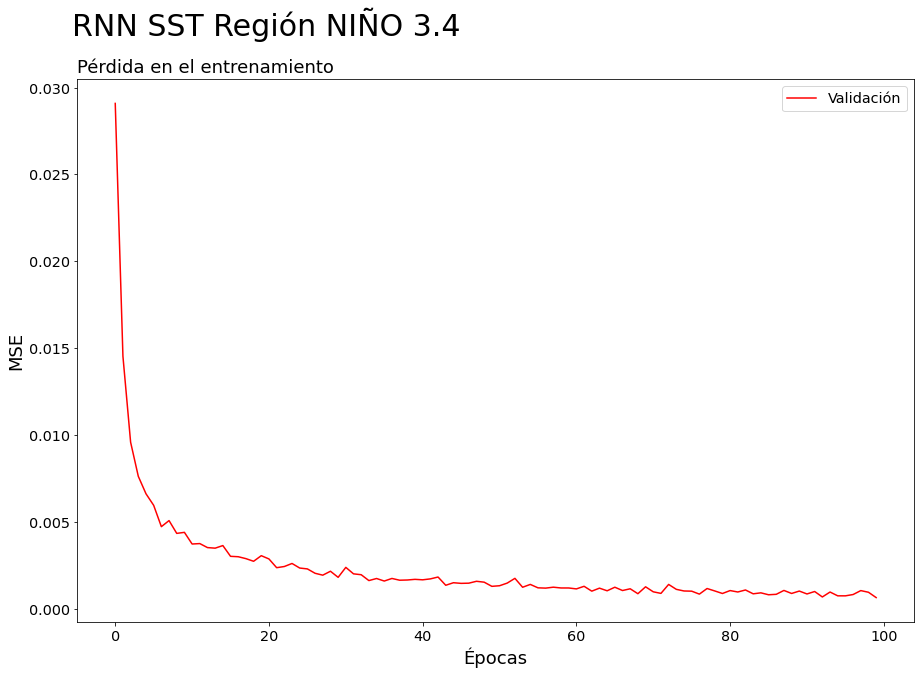

In [30]:
title = 'RNN SST Región NIÑO 3.4'

loss = history.history["loss"]
val_loss = history.history["loss"]
epochs = range(len(loss))
plt.figure(figsize=(15,10))
pylab.rcParams.update(params)
#plt.plot(epochs, loss, "b", label="Entrenamiento")
plt.plot(epochs, val_loss, "r", label="Validación")

plt.title('Pérdida en el entrenamiento',loc='left',fontsize=18)
plt.suptitle(title,ha='left',fontsize=30,x=0.12)
plt.xlabel("Épocas",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()

plt.savefig(f'{DIR}/{experimento}/loss_rnn_model_nino34.png')
plt.show()

Error absoluto medio

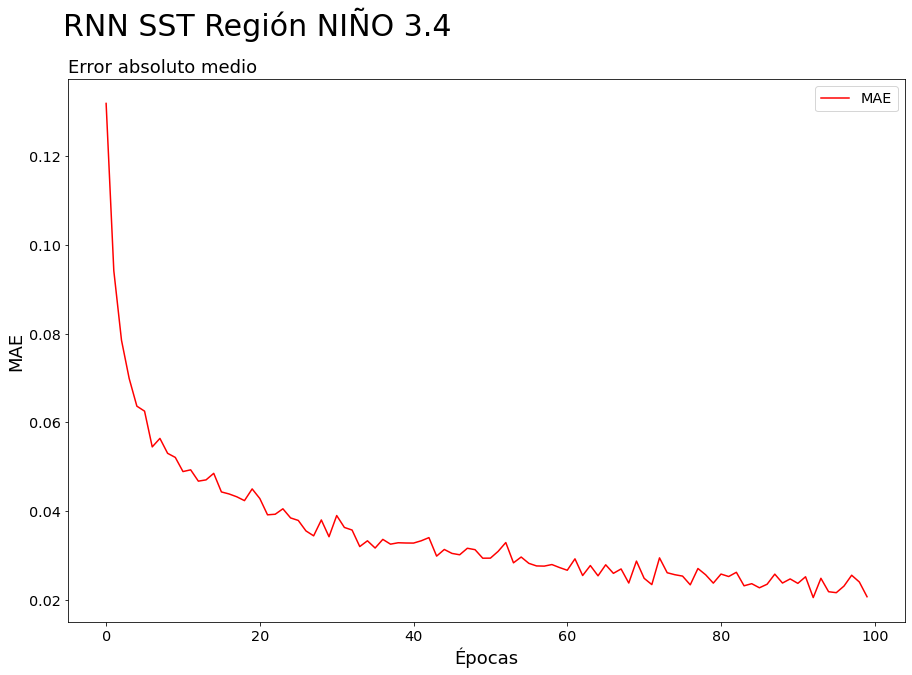

In [31]:
title = 'RNN SST Región NIÑO 3.4'
loss = history.history["loss"]
val_loss = history.history["mean_absolute_error"]
epochs = range(len(loss))
plt.figure(figsize=(15,10))
pylab.rcParams.update(params)
plt.plot(epochs, val_loss, "r", label="MAE")

plt.title('Error absoluto medio',loc='left',fontsize=18)
plt.suptitle(title,ha='left',fontsize=30,x=0.12)
plt.xlabel("Épocas",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()

plt.savefig(f'{DIR}/{experimento}/mae_rnn_model_nino34.png')
plt.show()

root mean squared error

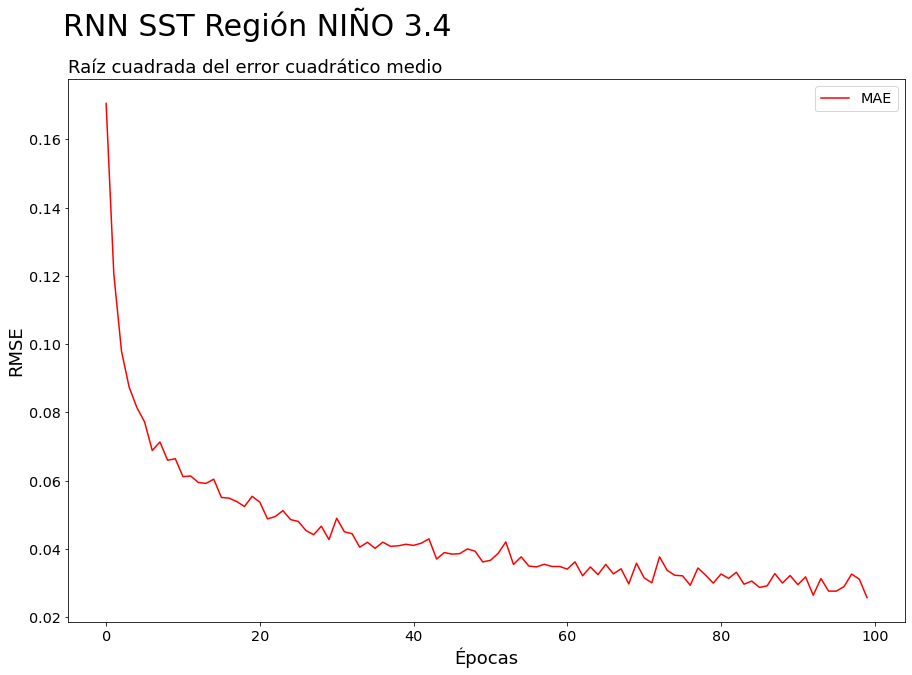

In [32]:
title = 'RNN SST Región NIÑO 3.4'
loss = history.history["loss"]
val_loss = history.history["root_mean_squared_error"]
epochs = range(len(loss))
plt.figure(figsize=(15,10))
pylab.rcParams.update(params)
plt.plot(epochs, val_loss, "r", label="MAE")

plt.title('Raíz cuadrada del error cuadrático medio',loc='left',fontsize=18)
plt.suptitle(title,ha='left',fontsize=30,x=0.12)
plt.xlabel("Épocas",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()

plt.savefig(f'{DIR}/{experimento}/rmse_rnn_model_nino34.png')
plt.show()

Resumen del modelos

In [33]:
dict_metrics = {'epocas':[len(history.epoch)],
                'prediction_order':[prediction_order],
                'auto_order':[auto_order],
                'training_mse':[history.history["loss"][-1]],
                'training_rmse':[history.history["root_mean_squared_error"][-1]],
                'training_mae':[history.history["mean_absolute_error"][-1]],
                'trainig_mape':[trainig_metrics['mape']],
                'trainig_r':[trainig_metrics['r2']],
                'validation_mse':[test_metrics["mse"]],
                'validation_rmse':[test_metrics["rmse"]],
                'validation_mae':[test_metrics["mae"]],
                'validation_mape':[test_metrics['mape']],
                'test_mse':[validatiojn_test_metrics["mse"]],
                'test_rmse':[validatiojn_test_metrics["rmse"]],
                'test_mae':[validatiojn_test_metrics["mae"]],
                'test_mape':[validatiojn_test_metrics['mape']]
                }

experimento_pd = pd.DataFrame.from_dict(dict_metrics)
experimento_pd.to_csv(f'{DIR}/{experimento}/summary_{prediction_order}_{auto_order}.csv',index=False)

In [34]:
experimento_pd

,epocas,prediction_order,auto_order,training_mse,training_rmse,training_mae,trainig_mape,trainig_r,validation_mse,validation_rmse,validation_mae,validation_mape,test_mse,test_rmse,test_mae,test_mape
0,100,18,192,0.000664,0.025773,0.020722,0.346125,0.984162,0.314942,0.099189,0.258718,0.977905,0.77699,0.603714,0.651227,2.487704
